**This project extends the basic autoencoder to denoise color images using the CIFAR-10 dataset. Unlike MNIST (grayscale), CIFAR-10 contains 32x32 RGB images, making it more challenging and realistic.**

In [1]:
!pip install -q tensorflow tensorflow-gpu
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, datasets, models

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Load & Preprocess CIFAR-10 Dataset

In [2]:
# Load CIFAR-10 dataset
(train_images, _), (test_images, _) = datasets.cifar10.load_data()

# Normalize pixel values (0-1)
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


**Add Noise to Images**
We'll add Gaussian noise to simulate real-world corruption.

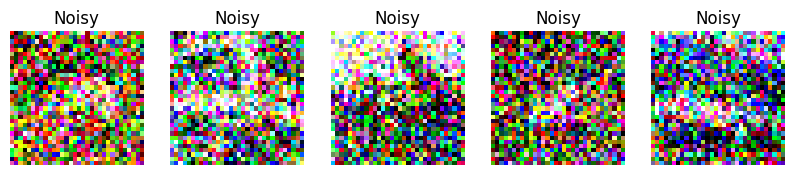

In [3]:
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0.0, 1.0)  # Ensure pixel values stay between 0-1
    return noisy_images

# Add noise to training and test images
train_noisy = add_noise(train_images)
test_noisy = add_noise(test_images)

# Visualize noisy images
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_noisy[i])
    plt.title("Noisy")
    plt.axis('off')
plt.show()

**Build the Autoencoder (CNN-based)** :
We use Convolutional layers for better feature extraction.

In [4]:
input_img = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')  # MSE works better for color images

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

Train the Autoencoder

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0237 - val_loss: 0.0130
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0112 - val_loss: 0.0113
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 12/20
391/391 ━━━━━━━━━━━━━━━━━━━━

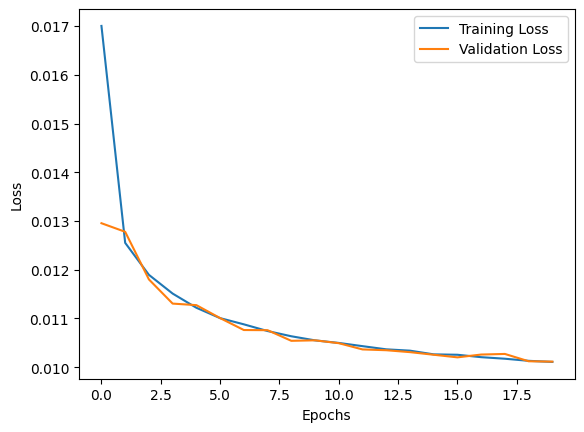

In [5]:
history = autoencoder.fit(
    train_noisy, train_images,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(test_noisy, test_images)
)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate & Visualize Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


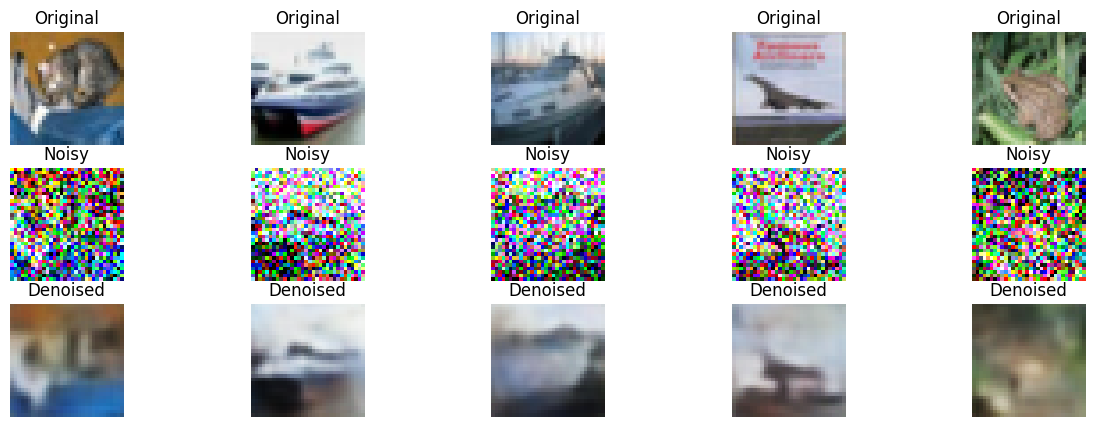

In [6]:
denoised_images = autoencoder.predict(test_noisy)

# Display original, noisy, and denoised images
plt.figure(figsize=(15, 5))
for i in range(5):
    # Original
    plt.subplot(3, 5, i+1)
    plt.imshow(test_images[i])
    plt.title("Original")
    plt.axis('off')

    # Noisy
    plt.subplot(3, 5, i+6)
    plt.imshow(test_noisy[i])
    plt.title("Noisy")
    plt.axis('off')

    # Denoised
    plt.subplot(3, 5, i+11)
    plt.imshow(denoised_images[i])
    plt.title("Denoised")
    plt.axis('off')
plt.show()

**Possible Improvements**
-Use a Deeper Network (e.g., ResNet-based autoencoder).

-Try Different Noise Types (Salt & Pepper, Speckle noise).

-Implement a Variational Autoencoder (VAE) for better latent space learning.

-Apply to Real-World Noisy Images (e.g., low-light photos).

